In [1]:
%pylab
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist, squareform, cdist

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import wfg

In [3]:
figsize(8,8)

Text(0.5, 0.98, 'WFG2')

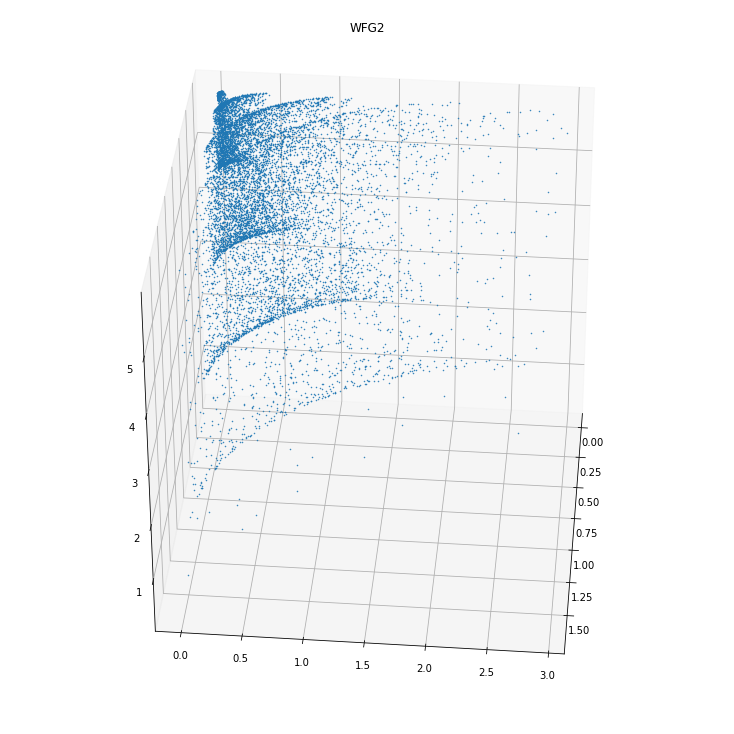

In [4]:
N = 10000
M = 3                                   # Number of objectives
kfactor = 2
lfactor = 2

k = kfactor*(M-1)
l = lfactor*2

func = wfg.WFG2

f = np.zeros((N, M))
for n in range(N):
    z = wfg.random_soln(k, l, func.__name__)
    f[n,:] = func(z, k, M)


fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
ax.plot(*f.T, '.', ms=1)
ax.view_init(elev=35, azim=5)
plt.suptitle(func.__name__)

In [5]:
def notDominated(X):
    """
    Return a Boolean vector with as many rows as X indicating whether each
    row of X is not dominated by the other elements of X; ie, whether each
    row is Pareto optimal for X.
    """
    y = zeros(X.shape[0], dtype='bool')
    for n in range(X.shape[0]):
        # Find the number of times on each row where X[i,j] >= X[n,j];
        # y[n] is not dominated if this is bigger than for every row
        y[n] = min(sum(X >= X[n,:], 1)) > 0
    return y

In [6]:
I = notDominated(f)
f = f[I,:]
f.shape

(2452, 3)

Text(0.5, 0.98, 'WFG2')

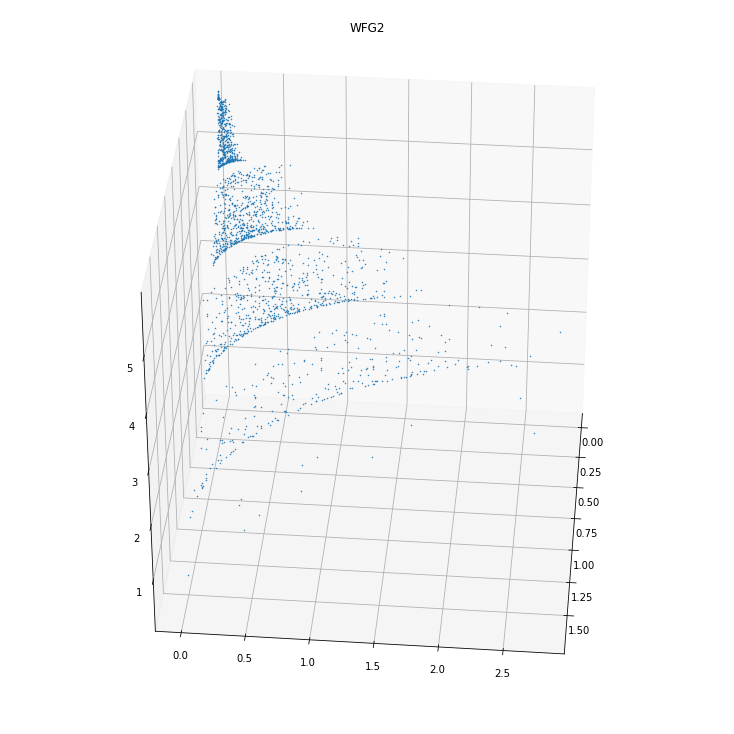

In [7]:
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
ax.plot(*f[:2000,:].T, '.', ms=1)
ax.view_init(elev=35, azim=5)
plt.suptitle(func.__name__)

In [1]:
M = 2000  # Number of points required

X = f[:M,:]
Y = f[M:,:]

D = squareform(pdist(X))
np.fill_diagonal(D, np.nan)
d = np.nanmin(D, axis=0)    # Nearest neighbour distances

mind, medd, maxd = [], [], []
for y in Y:
    dp = cdist(y[np.newaxis,:], X)[0]  # Distance of y to each element of X
    
    if np.nanmin(dp) > np.nanmin(d):
        # Insert y instead of one of the points that has the min nn distance in X
        # thus increasing the min nn distance
        i = np.nanargmin(d)

        X[i,:] = y[:]
        D[i,:] = dp
        D[:,i] = dp
        D[i,i] = np.nan
        d[i] = np.nanmin(dp)
    else:
        # Try using y if it would reduce the nn distance for a point that has
        # a nn distance larger than the median nn distance.
        
        # Disabled below by multipying median by 100.
        try: 
            i = nonzero((dp < d) & (dp > median(d)))[0][0]
        
            X[i,:] = y[:]
            D[i,:] = dp
            D[:,i] = dp
            D[i,i] = np.nan
            d[i] = np.nanmax(dp)
        except:
            pass
    
    mind.append(np.nanmin(D))
    maxd.append(np.nanmax(D))
    medd.append(np.nanmedian(D))

fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
ax.plot(*X.T, '.', ms=1)
ax.view_init(elev=35, azim=5)
plt.suptitle(func.__name__)

fig, ax = plt.subplots(3, 1, sharex=True)
for a, z in zip(ax, (mind, medd, maxd)):
    a.plot(z)


NameError: name 'f' is not defined

### Sample from the attainment surface 

In [9]:
def weak_dominates(Y, x):
    """
    Test whether rows of Y weakly dominate x
    
    Parameters
    ----------
    Y : array_like
        Array of points to be tested. 
        
    x : array_like
        Vector to be tested
        
    Returns
    -------
    c : ndarray (Bool)
        1d-array.  The ith element is True if Y[i] weakly dominates x
    """
    return (Y <= x ).sum(axis=1) == Y.shape[1]


def attainment_sample(Y, Nsamples=1000):
    """
    Return samples from the attainment surface defined by the mutually non-dominating set Y

    Parameters
    ---------
    Y : array_like
        The surface to be sampled. Each row of Y is vector, that is mutually
        with all the other rows of Y
    Nsamples : int
        Number of samples

    Returns
    -------
    S : ndarray
        Array of samples from the attainment surface.
        Shape; Nsamples by Y.shape[1] 
    
    Notes
    -----
    See "Dominance-based multi-objective simulated annealing"
    Kevin Smith, Richard Everson, Jonathan Fieldsend, 
    Chris Murphy, Rashmi Misra.
    IEEE Transactions on Evolutionary Computing. 
    Volume: 12, Issue: 3, June 2008.
    https://ieeexplore.ieee.org/abstract/document/4358782
    """
    N, D = Y.shape
    Ymin = Y.min(axis=0)
    r = Y.max(axis=0) - Ymin
    S = np.zeros((Nsamples, D))
    
    # Set up arrays of the points sorted according to each coordinate.
    Ys = np.zeros((N, D))
    for d in range(D):
        Ys[:,d] = np.sort(Y[:,d])

    for n in range(Nsamples):
        v = np.random.rand(D)*r + Ymin
        m = np.random.randint(D)

        # Bisection search to find the smallest v[m] 
        # so that v is weakly dominated by an element of Y
        lo, hi = 0, N
        while lo < hi:
            mid = (lo+hi)//2
            v[m] = Ys[mid,m]
            if not any(weak_dominates(Y, v)):
                lo = mid+1
            else:
                hi = mid
        if lo == N: lo -= 1
        v[m] = Ys[lo, m]      
        assert lo == N-1 or any(weak_dominates(Y, v))
        S[n,:] = v[:]
    return S


#### Example in 2D

In [10]:
N = 100
M = 2                                   # Number of objectives
kfactor = 2
lfactor = 2

k = kfactor*(M-1)
l = lfactor*2

func = wfg.WFG2

f = np.zeros((N, M))
for n in range(N):
    z = wfg.random_soln(k, l, func.__name__)
    f[n,:] = func(z, k, M)


I = notDominated(f)
f = f[I,:]
f.shape



(27, 2)

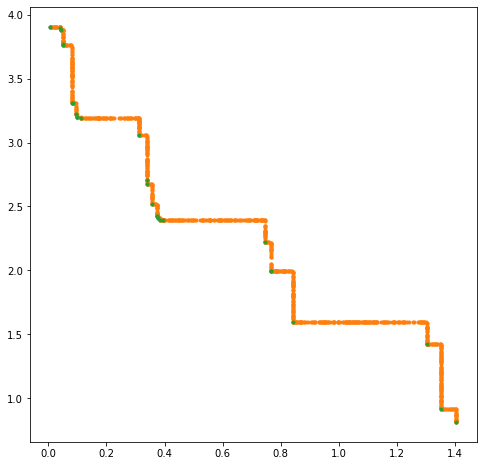

In [11]:
S = attainment_sample(f, 1000)

plt.plot(*f.T, '.')
plt.plot(*S.T, '.')
plt.plot(*f.T, '.')

#### 3 dimensions

Text(0.5, 0.98, 'WFG2')

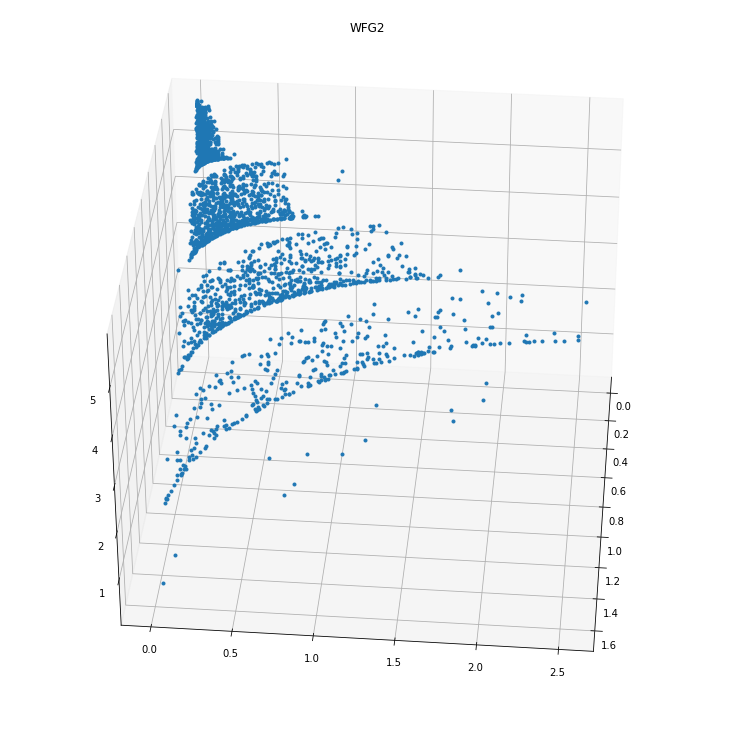

In [12]:
N = 10000
M = 3                                   # Number of objectives
kfactor = 2
lfactor = 2

k = kfactor*(M-1)
l = lfactor*2

func = wfg.WFG2

f3 = np.zeros((N, M))
for n in range(N):
    z = wfg.random_soln(k, l, func.__name__)
    f3[n,:] = func(z, k, M)


fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)

I = notDominated(f3)
f3 = f3[I,:]
f3.shape
plt.plot(*f3.T, '.')
ax.view_init(elev=35, azim=5)
plt.suptitle(func.__name__)


In [13]:
%matplotlib osx

In [14]:
S = attainment_sample(f3, 100000)
    
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
ax.plot(*S.T, '.', ms=1)
ax.view_init(elev=35, azim=5)
plt.suptitle(func.__name__ + ' attainment surface samples')

Text(0.5, 0.98, 'WFG2 attainment surface samples')